In [113]:
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Path for .pkl files
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\pilot_runs\\"
# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

In [114]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [ ]:
%%capture
%run "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\quail" "conduit.py"
# Run box to run

KeyboardInterrupt: 

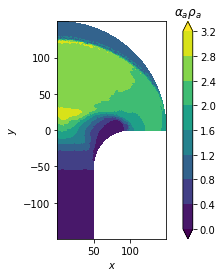

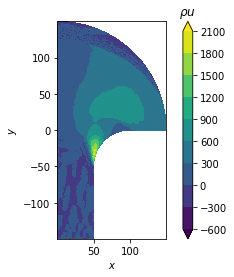

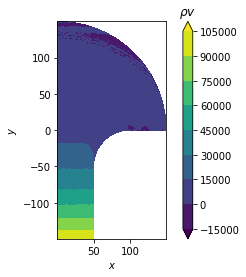

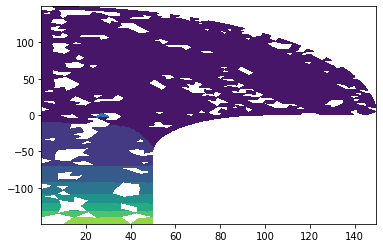

In [5]:
# Waves first arrive at left boundary of [-600,600] at ~ output20 (400ms)
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_21.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit2_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_52.pkl")
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_163.pkl")
#
#  for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.semilogy(solver.state_coeffs[:,:,i])

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [2]:
idx = 163
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{idx}.pkl")
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm2_{idx}.pkl")
plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

NameError: name 'readwritedatafiles' is not defined

In [116]:
import ternary
%matplotlib tk

idx = 5
# solver_atm1 = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{idx}.pkl")
# solver_atm2 = readwritedatafiles.read_data_file(f"mixture_shocktube_atm2_{idx}.pkl")
# solver_conduit1 = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{idx}.pkl")
# solver_conduit2 = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit2_{idx}.pkl")
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{idx}.pkl")
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{idx}.pkl")
solver_conduit2 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit2_{idx}.pkl")

fontsize = 12

def prep_ternary():
  ## Boundary and Gridlines
  scale = 100.0
  figure, tax = ternary.figure(scale=scale)

  # Draw Boundary and Gridlines
  tax.boundary(linewidth=2.0)
  tax.gridlines(color="black", multiple=10)
  tax.gridlines(color="blue", multiple=5, linewidth=0.1)

  # Set Axis labels and Title
  # Set ticks
  tax.ticks(axis='lbr', multiple=10, linewidth=2)

  ternary.plt.show()
  plt.box(False)

  # Remove default Matplotlib Axes
  tax.clear_matplotlib_ticks()
  return tax

def get_wt_percents(solver, coordset="AWvM"):
  rho = np.sum(solver.state_coeffs[:,:,solver.physics.get_mass_slice()], axis=2)
  if coordset == "AWvM":
    y1 = solver.state_coeffs[:,:,0] / rho * 100.0
    y2 = solver.state_coeffs[:,:,1] / rho * 100.0
    y3 = solver.state_coeffs[:,:,2] / rho * 100.0
    return list(zip(y1.ravel(), y2.ravel(), y3.ravel()))
  elif coordset == "AWtMd":
    y1 = solver.state_coeffs[:,:,0] / rho * 100.0
    # Water transform
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWd = arhoWt - solver.state_coeffs[:,:,1]
    y2 = arhoWt / rho * 100.0
    y3 = (solver.state_coeffs[:,:,2]-arhoWd) / rho * 100.0
  else:
    raise KeyError("Invalid coordset.")
  return list(zip(y1.ravel(), y2.ravel(), y3.ravel()))

''' Air, exsolved water, magma mixture'''
tax = prep_ternary()
tax.bottom_axis_label("wt% air", fontsize=fontsize)
tax.right_axis_label("wt% water, exsolved", fontsize=fontsize)
tax.left_axis_label("wt% frac melt + crystals + water, dissolved", fontsize=fontsize)

tax.right_corner_label("Air", fontsize=fontsize)
tax.top_corner_label("Exsolved water", fontsize=fontsize)
tax.left_corner_label("Magma", fontsize=fontsize)

tax.scatter(get_wt_percents(solver_atm1, "AWvM"), color='blue')
tax.scatter(get_wt_percents(solver_atm2, "AWvM"), color='red')
tax.scatter(get_wt_percents(solver_conduit1, "AWvM"), color='magenta')
tax.scatter(get_wt_percents(solver_conduit2, "AWvM"), color='cyan')
# tax.set_title("", fontsize=fontsize)

tax = prep_ternary()
tax.bottom_axis_label("wt% air", fontsize=fontsize)
tax.right_axis_label("wt% water, total", fontsize=fontsize)
tax.left_axis_label("wt% frac melt + crystals", fontsize=fontsize)

tax.right_corner_label("Air", fontsize=fontsize)
tax.top_corner_label("Total water", fontsize=fontsize)
tax.left_corner_label("Dry magma", fontsize=fontsize)

tax.scatter(get_wt_percents(solver_atm1, "AWtMd"), marker='d', color='blue', label="atm near")
tax.scatter(get_wt_percents(solver_atm2, "AWtMd"), marker='d', color='brown', label="atm far")
tax.scatter(get_wt_percents(solver_conduit1, "AWtMd"), marker='s', color='magenta', label="conduit upper")
tax.scatter(get_wt_percents(solver_conduit2, "AWtMd"), marker='s',color='cyan', label="conduit lower")

tax.legend()

In [199]:
%matplotlib agg
idx = 120
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{idx}.pkl")
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{idx}.pkl")
solver_conduit2 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit2_{idx}.pkl")

from matplotlib.animation import FuncAnimation
fig = plt.figure()
# ax = plt.axes(xlim=(-2400, 0), ylim=(0, 100e6)) # p
ax = plt.axes(xlim=(-2400, 0), ylim=(-3e2, 3e3)) # u, c
# ax = plt.axes(xlim=(-2400, 0), ylim=(-1, 10e9)) # wv
# ax = plt.axes()
line, = ax.plot([], [], lw=2)

def get_nodes(solver):
  nodal_pts = solver.basis.get_nodes(solver.order)
  # Allocate [ne] x [nb, ndims]
  x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
  for elem_ID in range(solver.mesh.num_elems):
    # Fill coordinates in physical space
    x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
  return x

def update(frame_index):
  frame_skip = 100
  solver_conduit1 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_conduit1_{frame_index+frame_skip}.pkl")
  x1 = get_nodes(solver_conduit1).ravel()
  p1 = solver_conduit1.physics.compute_additional_variable("Pressure", 
    solver_conduit1.state_coeffs, False).ravel()
  a1 = solver_conduit1.physics.compute_additional_variable("SoundSpeed", 
    solver_conduit1.state_coeffs, False).ravel()
  u1 = solver_conduit1.physics.compute_additional_variable("XVelocity", 
    solver_conduit1.state_coeffs, False).ravel()
  q1 = u1

  solver_conduit2 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_conduit2_{frame_index+frame_skip}.pkl")
  x2 = get_nodes(solver_conduit2).ravel()
  p2 = solver_conduit2.physics.compute_additional_variable("Pressure", 
    solver_conduit2.state_coeffs, False).ravel()
  a2 = solver_conduit2.physics.compute_additional_variable("SoundSpeed", 
    solver_conduit2.state_coeffs, False).ravel()
  u2 = solver_conduit2.physics.compute_additional_variable("XVelocity", 
    solver_conduit2.state_coeffs, False).ravel()
  q2 = u2

  x = np.concatenate((x2, x1))
  p = np.concatenate((q2, q1))
  
  line.set_data(x, p)
  return line,

# plot.plot_solution(solver_conduit1.mesh, solver_conduit1.physics, solver_conduit1, "Pressure",
#   plot_numerical=True, plot_exact=False, plot_IC=False,
#   create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
#   equidistant_pts=False, include_mesh=False, regular_2D=False,
#   equal_AR=equal_aspect_ratio)
# plot.plot_solution(solver_conduit2.mesh, solver_conduit2.physics, solver_conduit2, "Pressure",
#   plot_numerical=True, plot_exact=False, plot_IC=False,
#   create_new_figure=False, ylabel=None, fmt='b.', legend_label="DG",
#   equidistant_pts=False, include_mesh=False, regular_2D=False,
#   equal_AR=equal_aspect_ratio)
# solver_conduit1.time

def init():
    line.set_data([], [])
    return line,

anim = FuncAnimation(fig, update, frames=140,
    init_func=init, blit=True)
  
# anim.save('basic_animation_test', fps=30)

plt.show()




Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Python39\lib\tkinter\__init__.py", line 1884, in __call__
    return self.func(*args)
  File "c:\Python39\lib\tkinter\__init__.py", line 805, in callit
    func(*args)
  File "c:\Python39\lib\site-packages\matplotlib\backends\_backend_tk.py", line 139, in _on_timer
    super()._on_timer()
  File "c:\Python39\lib\site-packages\matplotlib\backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "c:\Python39\lib\site-packages\matplotlib\animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "c:\Python39\lib\site-packages\matplotlib\animation.py", line 1189, in _step
    self._draw_next_frame(framedata, self._blit)
  File "c:\Python39\lib\site-packages\matplotlib\animation.py", line 1209, in _draw_next_frame
    self._post_draw(framedata, blit)
  File "c:\Python39\lib\site-packages\matplotlib\animation.py", line 1232, in _post_draw
    self._blit_draw(self._drawn_a

In [111]:
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_288.pkl")

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

C:\Users\Fredric\Documents\Volcano\quail_volcano\src\processing\plot.py:787: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [ ]:
# Minimum of crystal partial density
np.min(solver.state_coeffs[:,:,6])

solver.state_coeffs[:,:,4]

In [304]:
snapshotidx = 163
snapshotidx = 163

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
x_conduit = solver.mesh.node_coords
p_conduit = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")

p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
mesh = solver.mesh
# plt.plot(p.ravel())
# plt.scatter(mesh.node_coords[:,0], mesh.node_coords[:,:,1], p)
mesh.node_coords.shape
x = plot.get_sample_points(
			mesh, solver, solver.physics, solver.basis, True)
plt.scatter(x.mean(axis=1)[:,0], x.mean(axis=1)[:,1],
  c=p.mean(axis=1)[:,0])
# x.mean(axis=1).shape
# p.mean(axis=1)[:,0].shape
plt.axis("equal")

plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

# Plot conduit
xnodes_conduit = np.zeros_like(p_conduit)
xnodes_conduit[:,0,:] = x_conduit[:-1]
xnodes_conduit[:,2,:] = x_conduit[1:]
xnodes_conduit[:,1,:] = 0.5*xnodes_conduit.sum(axis=1)
# plt.figure()
plt.plot(xnodes_conduit.ravel()-600, p_conduit.ravel() ,'.-')
plt.xlim([-100,100])
plt.ylim([5e4,300000])

(50000.0, 300000.0)

In [305]:
snapshotidx = 82
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")
num_saves = 82# 96
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
p_hist = np.zeros(tuple(size_tuple))
save_count = range(num_saves+1)
# x for 2D domain
x = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
x_conduit = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)
p_conduit_hist = np.zeros(tuple(size_tuple))


key_quant = "Pressure"
for i in save_count:
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{i}.pkl")
  p_conduit_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_conduit_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{i}.pkl")
  p_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  # Approximate energy
  # E_2D = np.sum(solver.state_coeffs[:,:,5])
  


# Problematic location
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
# plt.ylim([-150, -100])
# plt.xlim([0,50])
# plt.clim([-30000,60000*0])

# plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
# plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

In [311]:
import matplotlib.pyplot as plt
%matplotlib tk
# p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
# p [258,:,:]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

pseudo_x = x.mean(axis=1)[:,1]+150.0
ordering = np.argsort(pseudo_x)
X, Y = np.meshgrid(pseudo_x[ordering], save_count)
Z = p_hist[ordering,0,0,:].squeeze().T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# p_hist[:,:,-1]
# plt.xlabel("x")

ordering = np.argsort(pseudo_x)

plt.figure()
for i in (save_count):
  plt.plot(pseudo_x[ordering], p_hist[ordering,0,0,i], '.-')
  # plt.hold(True)

In [312]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_conduit.mean(axis=1).shape
pseudo_x_conduit = x_conduit.mean(axis=1)[:,0]-200
p_conduit_hist.mean(axis=1)[:,0,:]

ordering = np.argsort(pseudo_x_conduit)
X, Y = np.meshgrid(pseudo_x_conduit[ordering], save_count)
Z = p_conduit_hist.mean(axis=1)[ordering,0,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



In [313]:
x_global = np.append(pseudo_x, pseudo_x_conduit)
p_global = np.append(p_hist.squeeze(), p_conduit_hist.mean(axis=1)[:,0,:], axis=0)
# p_hist.squeeze().shape
# p_conduit_hist.mean(axis=1)[:,0,:].shape

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# x_global.mean(axis=1).shape

ordering = np.argsort(x_global)
X, Y = np.meshgrid(x_global[ordering], save_count)
Z = p_global[ordering,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, np.log10(Z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [309]:
assert(solver.physics.NDIMS == 2)
# np.argmin(p_hist[117,:,:])
p_hist[117,:,:,-1]
solver.state_coeffs[117,:,:]
# solver.physics.compute_additional_variable("Temperature", solver.state_coeffs, False)[258,:,:]

array([[ 3.209398680959025e+00,  6.665724146209232e-03,
         5.063518253989974e-02, -1.503678678149904e+01,
         1.361393929060994e+03,  1.428354681030915e+06,
         6.758441915463285e-03,  1.114944583298404e-04],
       [ 3.134122599140428e+00,  6.067382510697860e-03,
         2.029471026448680e-02, -1.854653209297979e+01,
         1.289081507291180e+03,  1.357347295645863e+06,
         6.013511292798749e-03, -5.584483382028718e-05],
       [ 3.027824059362930e+00,  1.029340383516750e-02,
         1.064434449730101e-02, -4.253785638997715e+00,
         1.235182497899851e+03,  1.294823621609165e+06,
         1.038956318848223e-02,  3.884263585032394e-05],
       [ 3.173723178153758e+00,  7.126932485094122e-03,
         6.907999843303714e-02, -1.622033319226930e+00,
         1.362400086291884e+03,  1.420015685576017e+06,
         7.254665140173486e-03,  1.436168986298273e-04],
       [ 3.136071658097668e+00,  6.320915136429413e-03,
         2.062913596830194e-02,  1.471428306